In [1]:
import jcopdl, luwiji
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [3]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms

bs = 28
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70), # diresize terlebih dahulu
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder("data/data/train/",transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/data/test/",transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [4]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([28, 3, 64, 64])

In [5]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [ ]:
# manual tanpa Block
# nn.Conv2d(3, 8, 3, 1, 1),
# nn.ReLU(),
# nn.MaxPool2d(2, 2)

In [6]:
from jcopdl.layers import conv_block, linear_block

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            linear_block(64*4*4, 256, dropout=0.1),
            linear_block(256, 2, activation='lsoftmax')
        )

    def forward(self, X):
        X = self.conv(X)
        X = self.fc(X)
        return X


In [7]:
config = set_config({
    "batch_size": bs,
    "crop_size": crop_size
})

# Training Preparation MCOC

In [8]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [9]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()

    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6827 | Test_cost  = 0.6250 | Train_score = 0.5260 | Test_score = 0.6575 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.5658 | Test_cost  = 0.5005 | Train_score = 0.7200 | Test_score = 0.7800 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.4435 | Test_cost  = 0.4184 | Train_score = 0.7950 | Test_score = 0.8225 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4627 | Test_cost  = 0.5389 | Train_score = 0.7840 | Test_score = 0.7375 |
==> EarlyStop patience =  1 | Best test_score: 0.8225


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4603 | Test_cost  = 0.5350 | Train_score = 0.7810 | Test_score = 0.7400 |
==> EarlyStop patience =  2 | Best test_score: 0.8225


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.4409 | Test_cost  = 0.3829 | Train_score = 0.7980 | Test_score = 0.8225 |
==> EarlyStop patience =  3 | Best test_score: 0.8225


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4086 | Test_cost  = 0.3867 | Train_score = 0.8120 | Test_score = 0.8250 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3781 | Test_cost  = 0.3491 | Train_score = 0.8390 | Test_score = 0.8500 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3516 | Test_cost  = 0.3689 | Train_score = 0.8410 | Test_score = 0.8400 |
==> EarlyStop patience =  1 | Best test_score: 0.8500


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3611 | Test_cost  = 0.3489 | Train_score = 0.8500 | Test_score = 0.8500 |
==> EarlyStop patience =  2 | Best test_score: 0.8500


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3666 | Test_cost  = 0.3989 | Train_score = 0.8440 | Test_score = 0.8200 |
==> EarlyStop patience =  3 | Best test_score: 0.8500


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3680 | Test_cost  = 0.3532 | Train_score = 0.8410 | Test_score = 0.8550 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3624 | Test_cost  = 0.3312 | Train_score = 0.8540 | Test_score = 0.8650 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3257 | Test_cost  = 0.3257 | Train_score = 0.8760 | Test_score = 0.8550 |
==> EarlyStop patience =  1 | Best test_score: 0.8650


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3318 | Test_cost  = 0.3319 | Train_score = 0.8540 | Test_score = 0.8650 |
==> EarlyStop patience =  2 | Best test_score: 0.8650


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3218 | Test_cost  = 0.2895 | Train_score = 0.8580 | Test_score = 0.8950 |


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2911 | Test_cost  = 0.3180 | Train_score = 0.8670 | Test_score = 0.8575 |
==> EarlyStop patience =  1 | Best test_score: 0.8950


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2983 | Test_cost  = 0.2690 | Train_score = 0.8640 | Test_score = 0.8925 |
==> EarlyStop patience =  2 | Best test_score: 0.8950


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.2960 | Test_cost  = 0.3039 | Train_score = 0.8790 | Test_score = 0.8750 |
==> EarlyStop patience =  3 | Best test_score: 0.8950


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.2838 | Test_cost  = 0.2859 | Train_score = 0.8920 | Test_score = 0.8875 |


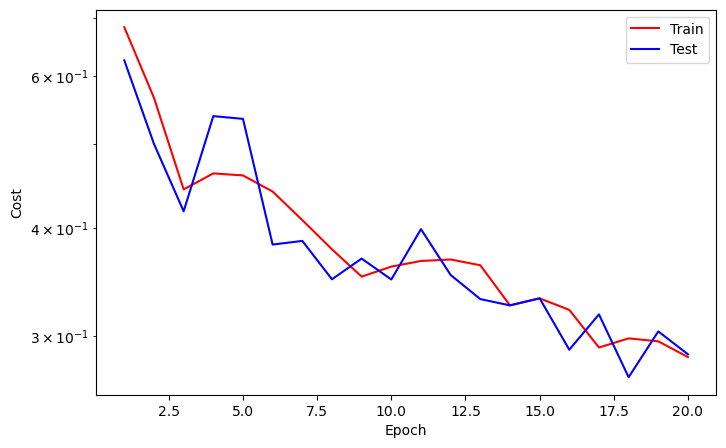

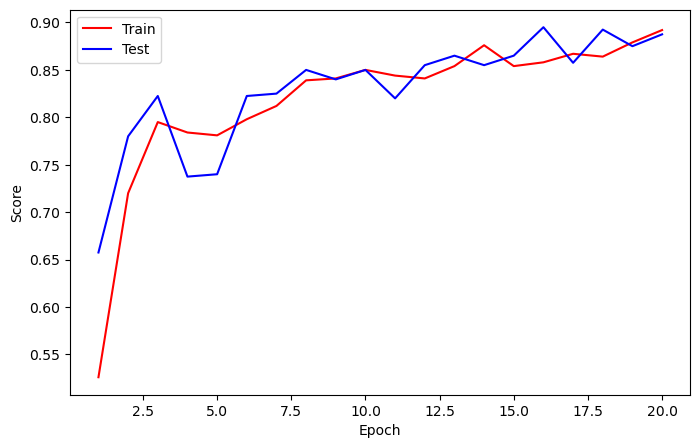

==> EarlyStop patience =  4 | Best test_score: 0.8950


Train:   0%|          | 0/36 [00:00<?, ?it/s]

Test:   0%|          | 0/15 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2536 | Test_cost  = 0.2773 | Train_score = 0.9000 | Test_score = 0.8800 |
==> EarlyStop patience =  5 | Best test_score: 0.8950
==> Execute Early Stopping at epoch: 21 | Best test_score: 0.8950
==> Best model is saved at model


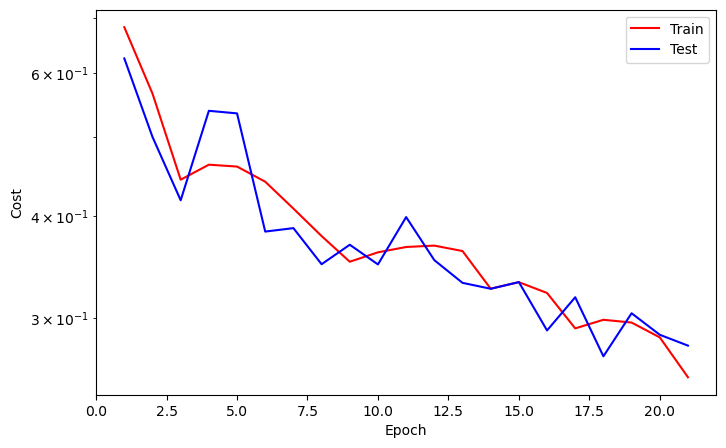

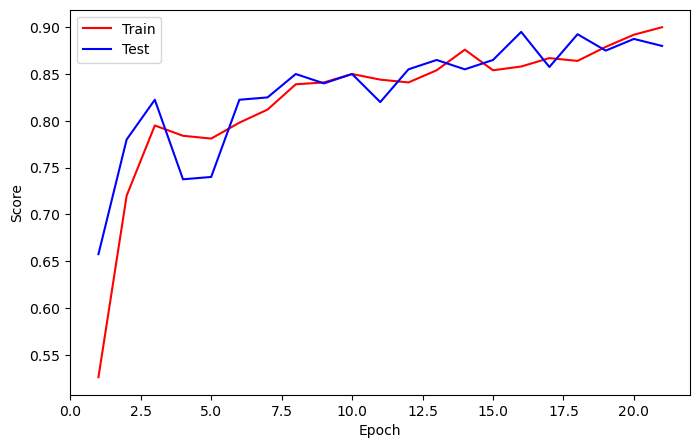

In [10]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)

    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint()

    # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'):
        callback.plot_cost()
        callback.plot_score()
        break

        

# Predict

In [11]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [12]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0])

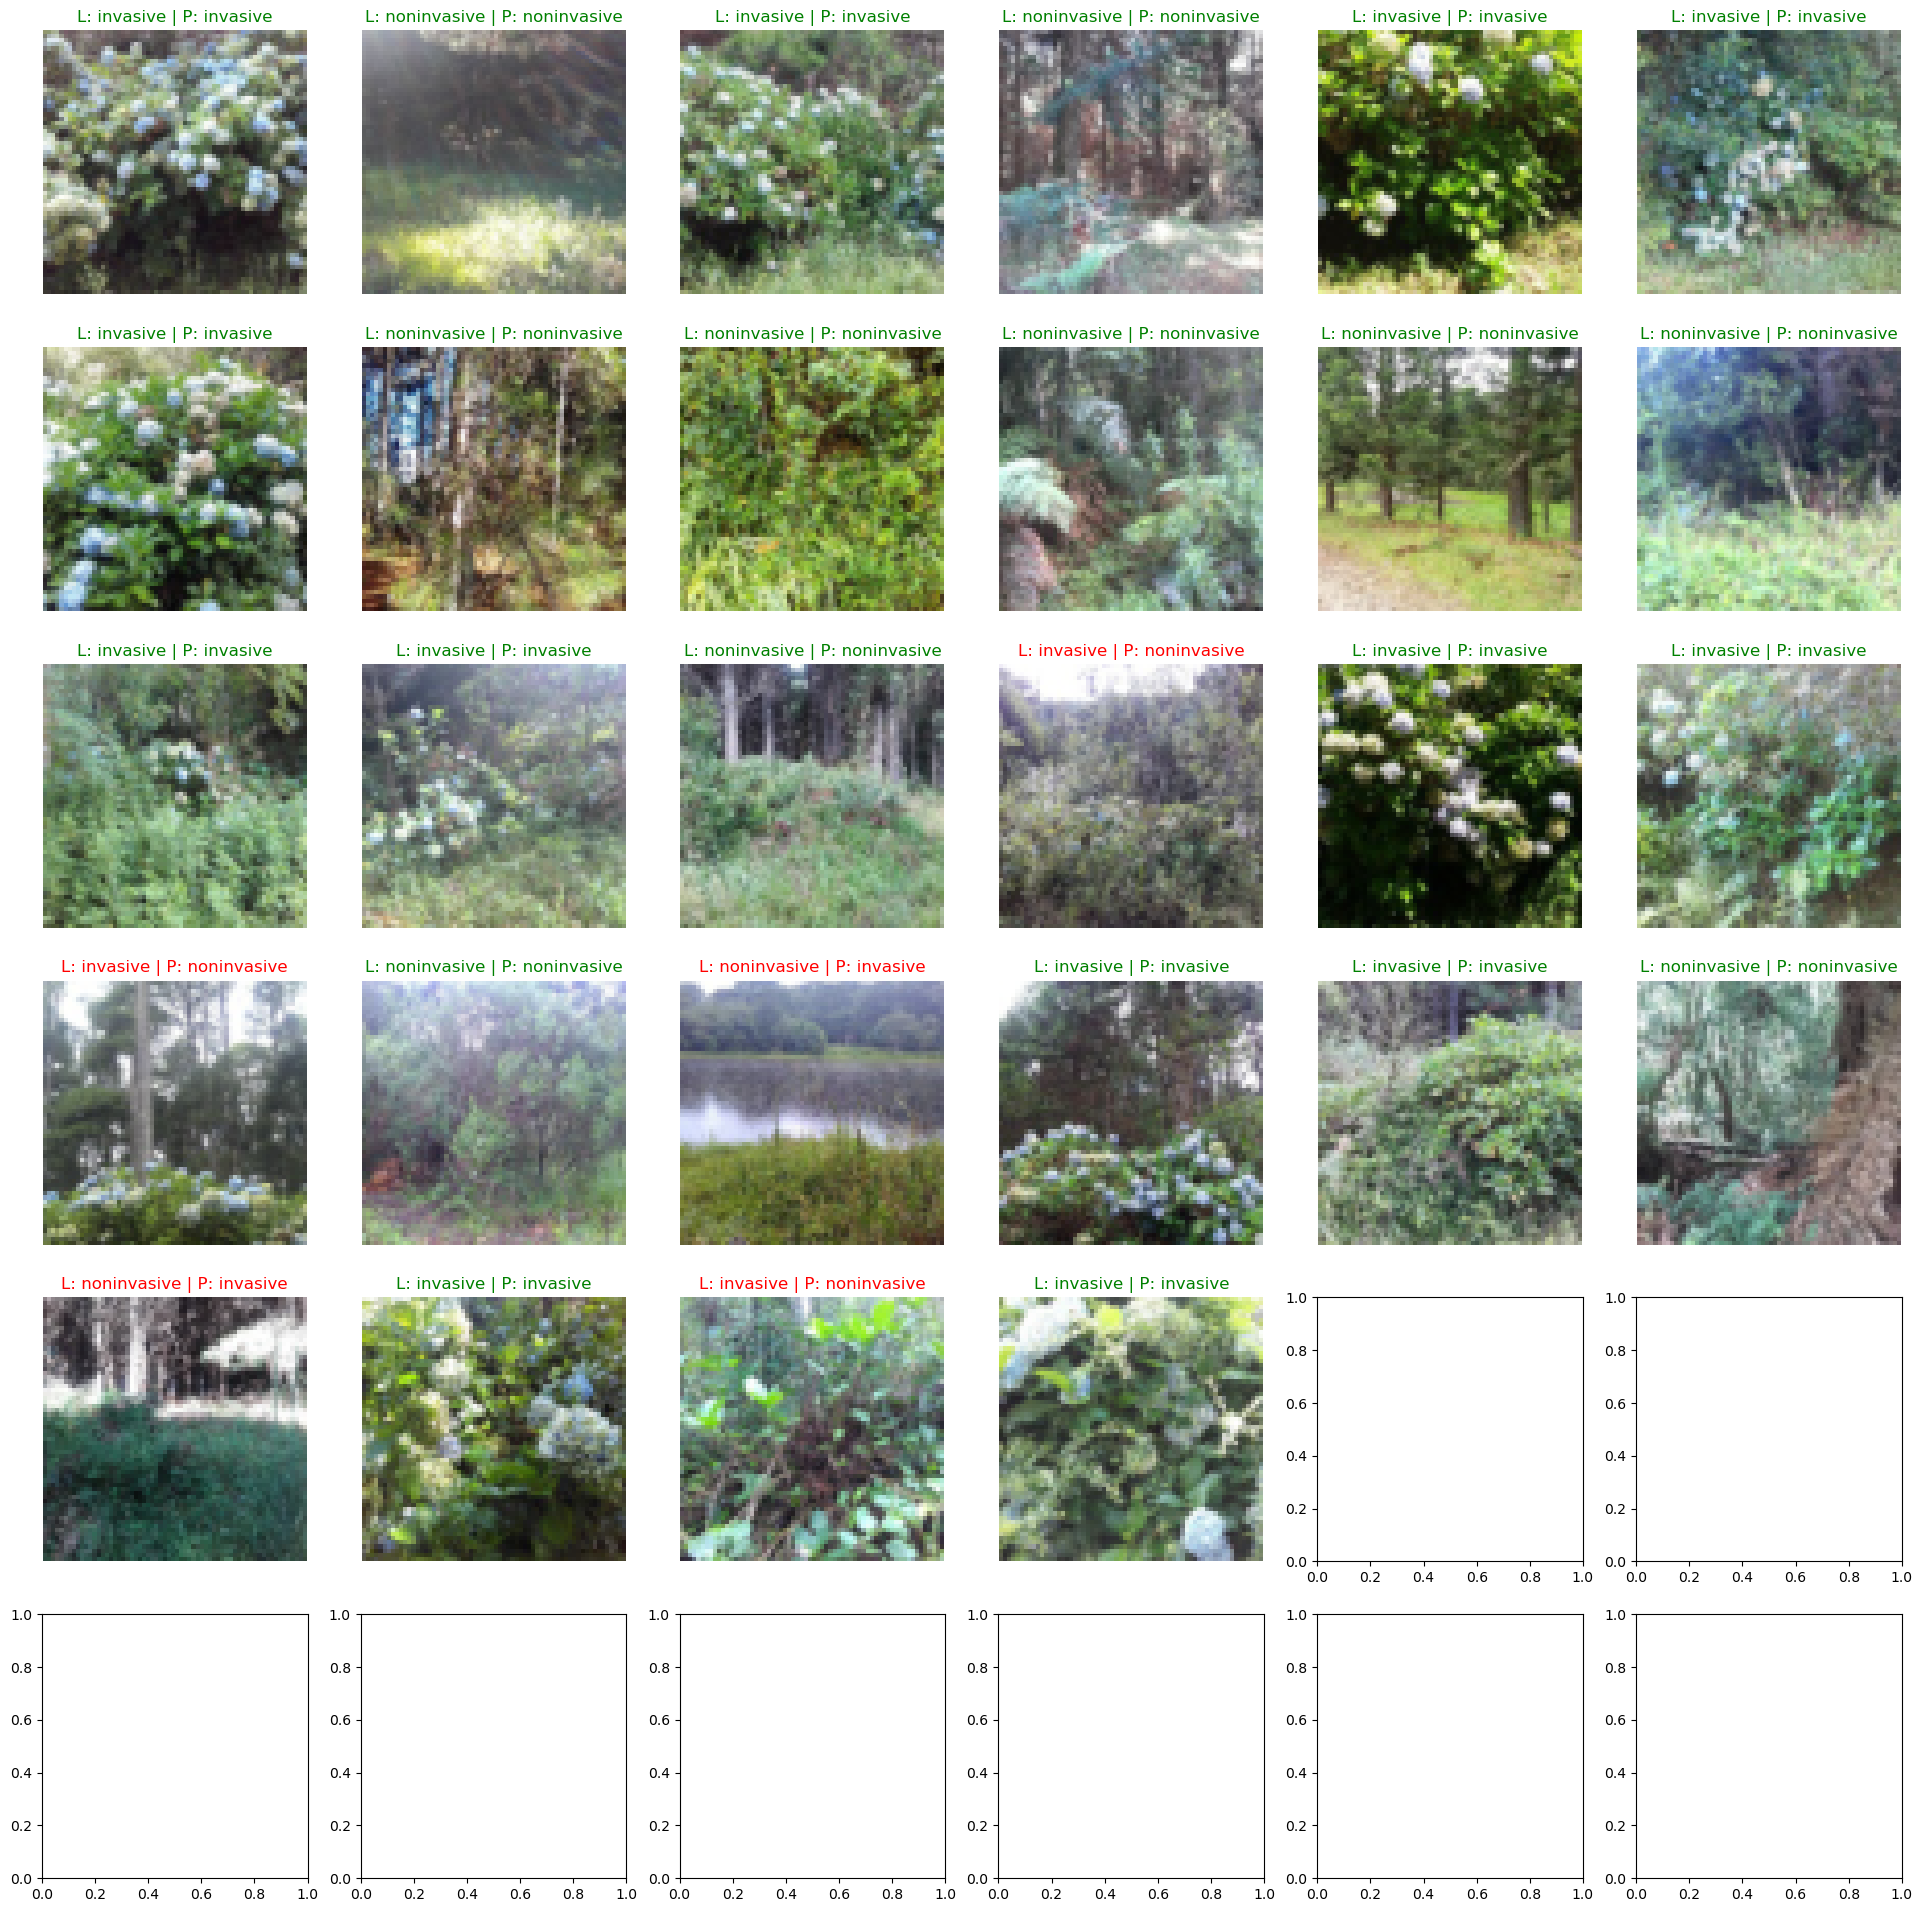

In [14]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {"color": "r"} if label != pred else {"color": "g"}
    label_pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label_pred[0]} | P: {label_pred[1]}", fontdict=font)
    ax.axis('off')
